<a href="https://colab.research.google.com/github/zilves27/PUC/blob/main/PUC_MVP_Sprint_II_DL_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***MVP 2 - Deep Learning - Ibovespa***

# ***1 - Definição do Problema***

* Descrição do problema: O problema consiste em prever o volume de negociação (Volume) do índice Bovespa (IBOVESPA) em um determinado dia com base em dados históricos;
* Premissas ou hipóteses sobre o problema: A previsão do volume de negociação é realizada com base nos dados históricos disponíveis e na arquitetura do modelo;
* Restrições ou condições impostas para selecionar os dados: Não foram aplicadas/identificadas restrições;
* Descrição do dataset: O dataset utilizado contém dados do índice Bovespa (IBOVESPA), nos quais foram extraídos do site "Investing.com", que é um site especializado e referência quando o assunto são ações. Além disso, os dados tem como base os 20 últimos meses (novembro/21 - junho/23) do ativo na bolsa, contendo:
      'Data': Representa as datas dos registros.
      'Fechamento': Representa o valor de fechamento do índice Bovespa na data correspondente.
      'Abertura': Representa o valor de abertura do índice Bovespa na data correspondente.
      'Max': Representa o valor máximo alcançado pelo índice Bovespa na data correspondente.
      'Min': Representa o valor mínimo alcançado pelo índice Bovespa na data correspondente.
      'Vol.': Representa o volume de negociação em R$ milhões na data correspondente.
      'Var%': Representa a variação percentual do índice Bovespa em comparação com a data anterior;

***Importação das bibliotecas necessárias***

In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Input
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# ***2 - Preparação dos dados***

* Separação entre treino e teste: O dataset foi dividido em 70% dos dados (290 dias) para treinamento e 30% (109 dias) para testes, onde teremos o período de 01/nov/21 até 29/dez/22 (último dia útil de operação) sendo utilizado como treinamento, para tentar prever os seis primeiros meses do ano de 2023, sendo esses utilziados como base de testes;
* Não aplicou validação cruzada, pois os dados foram separados manualmente;
* Transformação dos dados: para normalização dos dados das bases de treino e teste foi utilizado MinMaxScaler, garantindo assim que os valores estivessem no intervalo entre 0 e 1, facilitando o treino do modelo;

In [13]:
# Carregar o arquivo CSV diretamente do github
url = "https://raw.githubusercontent.com/zilves27/PUC/main/ibovespa_l20m.csv"
df = pd.read_csv(url, sep=";")
df['Vol.'] = df['Vol.'].str.replace(',', '.')
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)  # Converter a coluna "Data" para o formato de data

# Visualizar as primeiras linhas do Dataset
print(df.head())


        Data  Fechamento  Abertura      Max      Min   Vol.      Var%
0 2021-11-01     105.551   103.514  106.136  103.514  10.73  0.000000
1 2021-11-03     105.617   105.547  106.754  104.205  14.70  0.000625
2 2021-11-04     103.412   105.617  105.627  102.835  12.08 -0.020877
3 2021-11-05     104.824   103.412  105.555  103.412  12.59  0.013654
4 2021-11-08     104.781   104.824  105.679  104.182   9.36 -0.000410


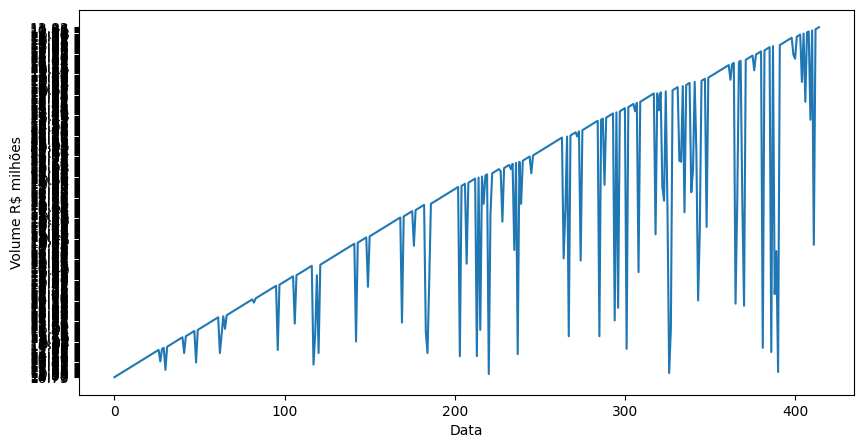

In [14]:
# Representação gráfica do Volume negociado em R$ milhões
data = df.iloc[:,5].values
plt.figure(figsize=(10, 5))
plt.xlabel('Data')
plt.ylabel('Volume R$ milhões')
plt.plot(data)

In [15]:
#Definindo data limite
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
data_comparacao = '2022-12-29'
mask = (df['Data'] == pd.to_datetime(data_comparacao))
df_filtrado = df.loc[mask]

print(df_filtrado)

train = data[:290]
test = data[291:]

          Data  Fechamento  Abertura      Max     Min   Vol.      Var%
290 2022-12-29     109.735   110.237  111.178  109.56  13.39 -0.004554


In [16]:
# Normalização dos dados das bases
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1,1))
test = sc.transform(test.reshape(-1,1))

# ***3 - Modelagem e Treinamento***

* Algoritmo escolhido: O modelo utilizado é uma rede neural do tipo LSTM, que nada mais é que uma arquitetura de rede recorrente especialmente adequada para lidar com dados sequenciais, como séries temporais. Além disso, trata-se de uma técnica avançada, podendo ser considerada uma abordagem bem complexa para o tipo de problema em questão
* Ajuste de hiperparâmetros: O modelo foi treinado com o otimizador Adam e função loss Mean Squared Error (MSE), sendo utiliziadas 45 épocas de treinamento com um tamanho de batch igual a 4.
* Foi utilizado intervalos de tempos de 15 dias, utilizando-os com dados de entrada, para assim gerar o volume (Vol.) do dia 16, criando intervalos de 15, tanto no treino, quanto no teste;
* A LSTM utilizada é composta de 16 neurômios, com camadas 4 camadas de densidade com respectivamente 8, 4, 2 e 1 neurônios cada e ativação relu;

In [17]:
# Definição dos parâmetros
X_train = []
y_train = []
for i in range(15, train.shape[0]):
    X_train.append(train[i-15:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
print(X_train.shape, y_train.shape)
print(X_train)
print(y_train[:2])

(275, 15) (275,)
[[0.26477655 0.45555022 0.32964921 ... 0.28255646 0.24939933 0.37530034]
 [0.45555022 0.32964921 0.35415666 ... 0.24939933 0.37530034 0.25228256]
 [0.32964921 0.35415666 0.19894282 ... 0.37530034 0.25228256 0.1283037 ]
 ...
 [0.34070159 0.3950024  0.41374339 ... 0.59634791 0.30129745 0.36665065]
 [0.3950024  0.41374339 0.46612206 ... 0.30129745 0.36665065 0.        ]
 [0.41374339 0.46612206 0.26237386 ... 0.36665065 0.         0.28543969]]
[0.25228256 0.1283037 ]


In [19]:
# Treinando o modelo
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
model = Sequential()
# Configauração LTSM
model.add(LSTM(16, input_shape=(X_train.shape[1], 1), activation='relu',kernel_initializer='lecun_uniform'))
#  Confirguração camdas
model.add(Dense(8))
model.add(Dense(4))
model.add(Dense(2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 45, batch_size = 4)

Epoch 1/45
69/69 [==============================] - 3s 7ms/step - loss: 0.0195
Epoch 2/45
69/69 [==============================] - 1s 12ms/step - loss: 0.0176
Epoch 3/45
69/69 [==============================] - 1s 13ms/step - loss: 0.0162
Epoch 4/45
69/69 [==============================] - 1s 13ms/step - loss: 0.0161
Epoch 5/45
69/69 [==============================] - 1s 12ms/step - loss: 0.0162
Epoch 6/45
69/69 [==============================] - 1s 10ms/step - loss: 0.0155
Epoch 7/45
69/69 [==============================] - 1s 9ms/step - loss: 0.0171
Epoch 8/45
69/69 [==============================] - 1s 8ms/step - loss: 0.0159
Epoch 9/45
69/69 [==============================] - 1s 8ms/step - loss: 0.0160
Epoch 10/45
69/69 [==============================] - 1s 8ms/step - loss: 0.0153
Epoch 11/45
69/69 [==============================] - 1s 9ms/step - loss: 0.0155
Epoch 12/45
69/69 [==============================] - 1s 9ms/step - loss: 0.0149
Epoch 13/45
69/69 [=========================

# ***4 - Resultados***

* Métricas de avaliação: A métrica utilizada para avaliar o desempenho do modelo é o Mean Squared Error (MSE), que mede a média dos quadrados dos erros entre os valores reais e previstos, sendo percebido valores muito similares nas bases de treino e teste;
* Quando se trata do mercado de ações, há uma série de fatores externos nos quais também podem influenciar no resultado do volume negociado do ativo, todavia os resultados podem sim ajudar bastante a traçar uma caminho e até mesmo na elaboração de uma estratégia;
* Avaliando os resultados da base de treino podemos perceber que os valores previstos (Vol. Previsto) não apresentaram tantas oscilações, mantendo uma amplitude relativamente baixa, além de que em vários momentos as linhas (Real x Previsto) se cruzam;
* Já na avaliação da base de teste vemos que o Vol. Previsto manteve o nível de amplitude relativamente baixo, porém as oscilações do Vol. Real presentes na base de teste foram grandes, onde em certos momentos temos momentos tivemos uma disparidade grande entre Real x Previsto, tanto para mais, quanto para menos, contudo como muitas vezes ocorre no mercado financeiro, os ativos acabam se estabilizando com o tempo, trazendo-os para uma medida central.



In [20]:
#Testando o modelo com um intervalo de 15
X_test = []
y_test = []
for i in range(15, test.shape[0]):
    X_test.append(test[i-15:i, 0])
    y_test.append(test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)

(109, 15)
(275, 15, 1)


9/9 [==============================] - 0s 5ms/step


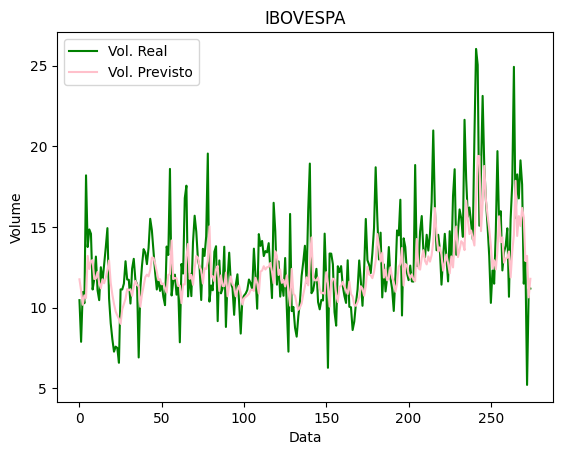

In [21]:
# Plotagem do previsto x real na base de treino
predicted = model.predict(X_train)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(train[-275:]), color = 'green', label = 'Vol. Real')
plt.plot(predicted, color = 'pink', label = 'Vol. Previsto')
plt.title('IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.legend()
plt.show()

4/4 [==============================] - 0s 5ms/step


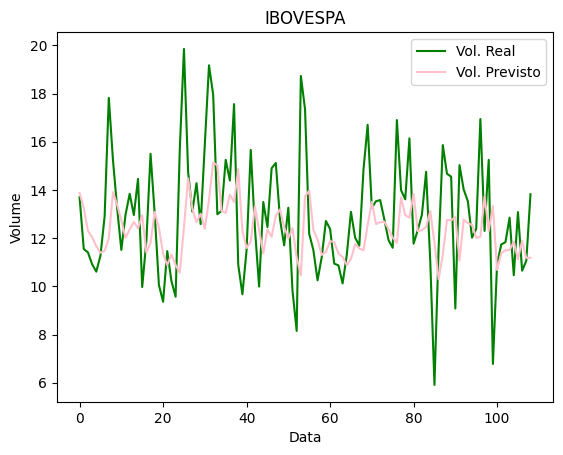

In [22]:
# Plotagem do previsto x real na base de teste
predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
plt.plot(sc.inverse_transform(test[-109:]), color = 'green', label = 'Vol. Real')
plt.plot(predicted, color = 'pink', label = 'Vol. Previsto')
plt.title('IBOVESPA')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.legend()
plt.show()